# Geo part

# Description for the Capstone Project

## Description of the problem and a discussion of the background.

### A. Problem

A coffee company would like to start its own chain shop. The company would like to start the new coffee shop with top 5 cities across the world, as there will be more high income customer who will be more willing to try new products. 

However, it is difficult to compete with the current top brand like STARBUCKS , COSTA , etc. The Company would like to know which areas of the city could be a good start place , the places have the customers and less competitors.

### B. Description of Data and how it will be used to solve the problem.

#### City Economy Data

Data Source: https://stats.oecd.org/

Will use the Top 5 total GDP cities
Will aslo use the top Top 5 GDP per capita cities

#### City Geo Data

Data Source: geopy api

#### City Venues Data

Data Source: FourSquare

#### How the data will be used

1. With the Economy Data to find the top 5 cities with total GDP , and top 5 cities with GDP per capita

2. Geopy API will provide the City boundingbox. With this box, will generate 100 points and get the venues according these points.

3. With the 100 points in each city , retrieve the venues data from FourSquare API.

4. Use Clustering method to cluster all the geo location point , find the locations which has most coffee shop and consider the points in the same cluster but with less coffee shops.

#### About how to retrieve the venues data of 100 points

As each city will have very different size bounding box, use the same radius when exploring the venues will cause huge missing area and overlap area.

To avoid this , I will use the mean value of the sum of length and width. Like the figure below.

![Radius Calculation](https://mybucket-zheng-20191223.s3.ap-northeast-2.amazonaws.com/radius.PNG)

# Install geopy and Folium

In [45]:
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: done

# All requested packages already installed.

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    brotlipy-0.7.0             |py36h8c4c3a4_1000         346 KB  conda-forge
    chardet-3.0.4              |py36h9f0ad1d_1006         188 KB  conda-forge
    cryptography-2.9.2         |   py36h45558ae_0         613 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    idna-2.10                  |     pyh9f0ad1d_0          52 KB  conda-forge


## Create the function which retrive the city geo data from geopy, and create 100 points in the city boundingbox area. 

In [5]:
from geopy.distance import distance
from geopy.distance import great_circle

import json, logging
from geopy.geocoders import Nominatim

def seperator(a,b):
    c = (b - a)/9
    return [round(a,7),round(a+c,7),round(a+c*2,7),round(a+c*3,7),round(a+c*4,7),round(a+c*5,7),round(a+c*6,7),round(a+c*7,7),round(a+c*8,7),round(b,7)]

def geo_point_creator(city):
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(city)
    lat_list = seperator(float(location.raw['boundingbox'][0]),float(location.raw['boundingbox'][1]))
    lon_list = seperator(float(location.raw['boundingbox'][2]),float(location.raw['boundingbox'][3]))
    point_list = []
    for lat in lat_list:
        for lon in lon_list:
            point_list.append([city,lat,lon])
    df_city = pd.DataFrame(point_list, columns=['city','lat','lng'])
    point0 = [float(df_city.loc[0,['lat']]),float(df_city.loc[0,['lng']])]
    point1 = [float(df_city.loc[1,['lat']]),float(df_city.loc[1,['lng']])]
    point10 = [float(df_city.loc[10,['lat']]),float(df_city.loc[10,['lng']])]
    rad1 = int(distance(point0, point1).meters//2)
    rad2 = int(distance(point0, point10).meters//2) 
    radius = (rad1 + rad2)//2
    #print(point0,point1,point10,rad1,rad2,radius)
    df_city['radius'] = radius
    return df_city

## Import the city economy data and requested model

In [2]:
import pandas as pd
import numpy as np
import requests
import re

df = pd.read_csv('CITIES_12062020101058739.csv')

Select the top5 city of the total GDP in 2018.

In [6]:
gdp_2018 = df[df['Year']==2018]
top5_gdpt_city = gdp_2018[gdp_2018['VAR']=='GDP_REAL_PPP'].sort_values(by='Value',ascending=False).reset_index().head()
for i,n in enumerate(top5_gdpt_city['METRO_ID'].to_list()):
    x = ''.join(re.findall(r'[A-Za-z]', n))
    top5_gdpt_city['Flags'][i] = top5_gdpt_city['Metropolitan areas'].to_list()[i].replace(' (Greater)','') + ', ' + x

gdpt = top5_gdpt_city['Flags'].to_list()
gdpt[2] = 'Seoul'
gdpt

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


['New York, USA', 'Los Angeles, USA', 'Seoul', 'Washington, USA', 'Paris, FR']

Select the top5 city of the GDP per capita in 2018

In [7]:
top5_gdpp_city = gdp_2018[gdp_2018['VAR']=='GDP_PC_REAL_PPP'].sort_values(by='Value',ascending=False).reset_index().head()
for i,n in enumerate(top5_gdpp_city['METRO_ID'].to_list()):
    x = ''.join(re.findall(r'[A-Za-z]', n))
    top5_gdpp_city['Flags'][i] = top5_gdpp_city['Metropolitan areas'].to_list()[i].replace(' (Greater)','') + ', ' + x
gdpp = top5_gdpp_city['Flags'].to_list()
gdpp

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


['Cork, IE',
 'San Francisco, USA',
 'Durham, USA',
 'Luxembourg, LU',
 'Washington, USA']

## Create the function to retrieve the Venues data from Foursquare API.|

In [8]:
CLIENT_ID = 'GBHOGHOE3DL1WYFOB4W5WI5SM1PLH1MDY4WN3O12SFGOVDUU' # your Foursquare ID
CLIENT_SECRET = 'AI25GODMBYEC331GD1VSY4Y3MRBP3SKR15N2YC01VKLSR0U4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
LIMIT = 100

Your credentails:
CLIENT_ID: GBHOGHOE3DL1WYFOB4W5WI5SM1PLH1MDY4WN3O12SFGOVDUU
CLIENT_SECRET:AI25GODMBYEC331GD1VSY4Y3MRBP3SKR15N2YC01VKLSR0U4


In [9]:
def getNearbyVenues(names, latitudes, longitudes, radiuses):
    
    venues_list=[]
    for name, lat, lng, radius in zip(names, latitudes, longitudes, radiuses):
        #print('{},{},{}'.format(lat,lng,radius))
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City Name',
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Select the 3 cities from top5 of total GDP, and 2 cities from top5 of GDP per capita cities.

In [10]:
city_list = gdpt

In [11]:
city_point_gdpt = pd.DataFrame(columns=['city','lat','lng','radius'])
for city in city_list:
    df_tmp = geo_point_creator(city)
    city_point_gdpt = city_point_gdpt.append(df_tmp, ignore_index=True)
NY_point = city_point_gdpt[city_point_gdpt['city']=='New York, USA']
LA_point = city_point_gdpt[city_point_gdpt['city']=='Los Angeles, USA']
Paris_point = city_point_gdpt[city_point_gdpt['city']=='Paris, FR']

In [12]:
city_list = gdpp
city_point_gdpp = pd.DataFrame(columns=['city','lat','lng','radius'])
for city in city_list:
    df_tmp = geo_point_creator(city)
    city_point_gdpp = city_point_gdpp.append(df_tmp, ignore_index=True)

In [13]:
SF_point = city_point_gdpp[city_point_gdpp['city']=='San Francisco, USA']
DC_point = city_point_gdpp[city_point_gdpp['city']=='Washington, USA']

In [14]:
city_point = pd.DataFrame(columns=['city','lat','lng','radius'])
city_point = city_point.append(NY_point, ignore_index=True)
city_point = city_point.append(LA_point, ignore_index=True)
city_point = city_point.append(DC_point, ignore_index=True)
city_point = city_point.append(SF_point, ignore_index=True)
city_point = city_point.append(Paris_point, ignore_index=True)


In [15]:
city_point.shape

(500, 4)

In [56]:
SF_point.head()

,city,lat,lng,radius
100,"San Francisco, USA",37.640314,-123.173825,3080
101,"San Francisco, USA",37.640314,-123.074675,3080
102,"San Francisco, USA",37.640314,-122.975526,3080
103,"San Francisco, USA",37.640314,-122.876376,3080
104,"San Francisco, USA",37.640314,-122.777227,3080


Use the get city venues function to retieve the data of each cities. As there are 100 points data of each city, I have to seperate the retrieving process , as the Foursquare API may encounter the timeout error and failed the whole retrieving process.

In [ ]:
NY_venues = getNearbyVenues(names=NY_point['city'],
                              latitudes=NY_point['lat'],
                              longitudes=NY_point['lng'],
                              radiuses=NY_point['radius']
                             )

In [24]:
LA_venues = getNearbyVenues(names=LA_point['city'],
                              latitudes=LA_point['lat'],
                              longitudes=LA_point['lng'],
                              radiuses=LA_point['radius']
                             )

In [32]:
DC_venues = getNearbyVenues(names=DC_point['city'],
                              latitudes=DC_point['lat'],
                              longitudes=DC_point['lng'],
                              radiuses=DC_point['radius']
                             )

In [37]:
Paris_venues = getNearbyVenues(names=Paris_point['city'],
                              latitudes=Paris_point['lat'],
                              longitudes=Paris_point['lng'],
                              radiuses=Paris_point['radius']
                             )

In [10]:
SF_venues = getNearbyVenues(names=SF_point['city'],
                              latitudes=SF_point['lat'],
                              longitudes=SF_point['lng'],
                              radiuses=SF_point['radius']
                             )

In [26]:
LA_venues.to_csv('LA_venues.csv')

In [22]:
NY_venues.to_csv('NY_venues.csv')

In [34]:
DC_venues.to_csv('DC_venues.csv')

In [40]:
Paris_venues.to_csv('Paris_venues.csv')

In [12]:
SF_venues.to_csv('SF_venues.csv')

In [16]:
LA_venues = pd.read_csv('LA_venues.csv')
NY_venues = pd.read_csv('NY_venues.csv')
DC_venues = pd.read_csv('DC_venues.csv')
Paris_venues = pd.read_csv('Paris_venues.csv')
SF_venues = pd.read_csv('SF_venues.csv')

In [4]:
LA_venues.columns

Index(['Unnamed: 0', 'City Name', 'Latitude', 'Longitude', 'Venue',
       'Venue Latitude', 'Venue Longitude', 'Venue Category'],
      dtype='object')

Merge all the Dataframe to one.

In [17]:
cities_venues = pd.DataFrame(columns=['Unnamed: 0', 'City Name', 'Latitude', 'Longitude', 'Venue',
       'Venue Latitude', 'Venue Longitude', 'Venue Category'])
cities_venues = cities_venues.append(LA_venues, ignore_index=True)
cities_venues = cities_venues.append(NY_venues, ignore_index=True)
cities_venues = cities_venues.append(DC_venues, ignore_index=True)
cities_venues = cities_venues.append(Paris_venues, ignore_index=True)
cities_venues = cities_venues.append(SF_venues, ignore_index=True)

In [18]:
print('There are {} uniques categories.'.format(len(cities_venues['Venue Category'].unique())))

There are 542 uniques categories.


Create the onehot DataFrame for the clustering.

In [19]:
city_onehot = pd.get_dummies(cities_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
city_onehot['Latitude'] = cities_venues['Latitude'] 
city_onehot['Longitude'] = cities_venues['Longitude'] 
# move neighborhood column to the first column
fixed_columns = [city_onehot.columns[-1]] + list(city_onehot.columns[:-1])
city_onehot = city_onehot[fixed_columns]

city_onehot.head()

,Longitude,ATM,Acai House,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,...,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit,Latitude
0,-118.440230,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,33.659541
1,-118.326256,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,33.659541
2,-118.326256,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,33.659541
3,-118.326256,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,33.659541
4,-118.269269,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,33.659541


In [20]:
city_grouped = city_onehot.groupby(['Latitude','Longitude']).mean().reset_index()

## Use the KMeans to cluster all the geo points to get the cluster that have more coffee shop.

In [21]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 10

city_grouped_clustering = city_grouped.drop(['Latitude','Longitude'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:100]

array([1, 3, 3, 8, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 6, 6, 3, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0,
       4, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 4, 0, 0, 4, 4, 0, 0, 0, 0, 3, 0, 0,
       5, 2, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0], dtype=int32)

In [22]:
city_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

city_merged = city_point

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
city_merged = city_merged.join(city_grouped.set_index(['Latitude','Longitude']), on=['lat','lng'])


city_merged.dropna(inplace=True)

In [23]:
city_merged.shape

(219, 547)

In [24]:
df_coffee = city_merged.loc[:,['city','lat','lng','radius','Cluster Labels','Coffee Shop','Café']]
df_coffee['counter'] = df_coffee['Coffee Shop'] + df_coffee['Café']

In [25]:
df_coffee.groupby(['Cluster Labels']).mean()

,lat,lng,Coffee Shop,Café,counter
Cluster Labels,,,,,
0.0,39.682453,-76.764760,0.024960,0.011740,0.036699
1.0,37.168154,-96.285002,0.000000,0.000000,0.000000
2.0,40.721165,-73.700181,0.000000,0.000000,0.000000
3.0,36.359199,-108.190872,0.000000,0.000000,0.000000
4.0,36.645571,-111.835580,0.000000,0.008333,0.008333
7.0,37.929811,-122.777227,0.000000,0.000000,0.000000
8.0,37.174792,-96.133585,0.000000,0.000000,0.000000
9.0,48.861124,2.305444,0.008025,0.019338,0.027363


Draw the picture for the df_coffee data frame to check which cluster have more coffee.

In [9]:
import seaborn as sns

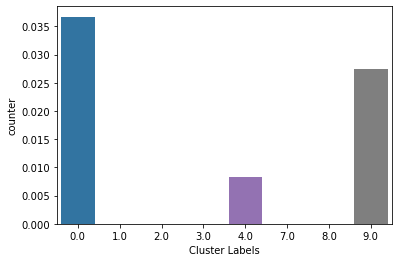

In [14]:
sns.barplot(x=df_coffee['Cluster Labels'],y=df_coffee['counter'])

According to the bar plot , we could see , the Labels 0.0 and 9.0 have the most of the frequency of the coffee shop

In [26]:
df_coffee = df_coffee[(df_coffee['Cluster Labels']==0.0) | (df_coffee['Cluster Labels']==9.0)]

In [27]:
df_coffee['counter'].describe()

count    201.000000
mean       0.034423
std        0.032448
min        0.000000
25%        0.010000
50%        0.030000
75%        0.050000
max        0.160000
Name: counter, dtype: float64

We choose the 50 percentile and 75 percentile as the target group.

In [28]:
df_coffee = df_coffee[(df_coffee['counter']>0.03) & (df_coffee['counter'] < 0.05)]

In [52]:
df_coffee.to_csv('df_coffee.csv')

## After the target points have been selected, we will start to drawing the circle on the map

In [82]:
df_coffee['city'].unique()

array(['New York, USA', 'Los Angeles, USA', 'Washington, USA',
       'Paris, FR'], dtype=object)

In [107]:
dc_coffee = df_coffee[df_coffee.city=='Washington, USA']
la_coffee = df_coffee[df_coffee.city=='Los Angeles, USA']
paris_coffee = df_coffee[df_coffee.city=='Paris, FR']
ny_coffee = df_coffee[df_coffee.city=='New York, USA']

In [42]:
geolocator = Nominatim(user_agent="ny_explorer")
ny_location = geolocator.geocode('New York, USA')
la_location = geolocator.geocode('Los Angeles, USA')
dc_location = geolocator.geocode('Washington, USA')
sf_location = geolocator.geocode('San Francisco, USA')
paris_location = geolocator.geocode('Paris, FR')

In [ ]:
dc_venues_map = folium.Map(location=[dc_location.latitude, dc_location.longitude], zoom_start=11, min_zoom=11,max_zoom=11) # generate map centred around the Conrad Hotel

for lat, lng, rad in zip(dc_coffee.lat, dc_coffee.lng, dc_coffee.radius):
    folium.features.CircleMarker(
        [lat, lng],
        radius=rad//55,
        color='blue',
        fill = True,
        fill_color='blue',
        fill_opacity=0.3
    ).add_to(dc_venues_map)
dc_venues_map.save('dc.html')
# display map
dc_venues_map

![dc_map](https://github.com/nforev/Coursera_Capstone/raw/master/image/dc_map.PNG)

In [119]:
ny_venues_map = folium.Map(location=[ny_location.latitude, ny_location.longitude], zoom_start=10, min_zoom=10,max_zoom=10) # generate map centred around the Conrad Hotel

for lat, lng, rad in zip(ny_coffee.lat, ny_coffee.lng, ny_coffee.radius):
    folium.features.CircleMarker(
        [lat, lng],
        radius=23.5,
        color='blue',
        fill = True,
        fill_color='blue',
        fill_opacity=0.3
    ).add_to(ny_venues_map)

ny_venues_map.save('ny.html')
# display map
ny_venues_map

![ny map](https://github.com/nforev/Coursera_Capstone/raw/master/image/ny_map.PNG)

In [122]:
la_venues_map = folium.Map(location=[la_location.latitude, la_location.longitude], zoom_start=10, min_zoom=10,max_zoom=10) # generate map centred around the Conrad Hotel

for lat, lng, rad in zip(la_coffee.lat, la_coffee.lng, la_coffee.radius):
    folium.features.CircleMarker(
        [lat, lng],
        radius=23.5,
        color='blue',
        fill = True,
        fill_color='blue',
        fill_opacity=0.3
    ).add_to(la_venues_map)

la_venues_map.save('la.html')
# display map
la_venues_map

![la_map](https://github.com/nforev/Coursera_Capstone/raw/master/image/la_map.PNG)

In [131]:
paris_venues_map = folium.Map(location=[paris_location.latitude, paris_location.longitude], zoom_start=12, min_zoom=12,max_zoom=12) # generate map centred around the Conrad Hotel

for lat, lng, rad in zip(Paris_point.lat, Paris_point.lng, Paris_point.radius):
    folium.features.CircleMarker(
        [lat, lng],
        radius=30,
        color='blue',
        fill = True,
        fill_color='blue',
        fill_opacity=0.3
    ).add_to(paris_venues_map)

#paris_venues_map.save('paris.html')
# display map
paris_venues_map

![paris_map](https://github.com/nforev/Coursera_Capstone/raw/master/image/paris_map.PNG)